In [1]:
#https://github.com/velocyto-team/velocyto-notebooks/blob/master/python/DentateGyrus.ipynb

import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import loompy
import velocyto as vcy
import logging
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.interpolate import interp1d

logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG)
%matplotlib inline
plt.rcParams['pdf.fonttype'] = 42

# plotting utility functions
def despline():
    ax1 = plt.gca()
    # Hide the right and top spines
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax1.yaxis.set_ticks_position('left')
    ax1.xaxis.set_ticks_position('bottom')
    
def minimal_xticks(start, end):
    end_ = np.around(end, -int(np.log10(end))+1)
    xlims = np.linspace(start, end_, 5)
    xlims_tx = [""]*len(xlims)
    xlims_tx[0], xlims_tx[-1] = f"{xlims[0]:.0f}", f"{xlims[-1]:.02f}"
    plt.xticks(xlims, xlims_tx)

    
def minimal_yticks(start, end):
    end_ = np.around(end, -int(np.log10(end))+1)
    ylims = np.linspace(start, end_, 5)
    ylims_tx = [""]*len(ylims)
    ylims_tx[0], ylims_tx[-1] = f"{ylims[0]:.0f}", f"{ylims[-1]:.02f}"
    plt.yticks(ylims, ylims_tx)


#!mkdir data
#from urllib.request import urlretrieve
#urlretrieve("http://pklab.med.harvard.edu/velocyto/DentateGyrus/DentateGyrus.loom", "data/DentateGyrus.loom")

# Crate an analysis object
vlm = vcy.VelocytoLoom("/Users/shengyuli/Library/CloudStorage/OneDrive-HoustonMethodist/work/Velocity/data/velocyto/neuro/raw_data/DentateGyrus.loom")

# Read column attributes form the loom file and specify colors
vlm.ts = np.column_stack([vlm.ca["TSNE1"], vlm.ca["TSNE2"]])
colors_dict = {'RadialGlia': np.array([ 0.95,  0.6,  0.1]), 'RadialGlia2': np.array([ 0.85,  0.3,  0.1]), 'ImmAstro': np.array([ 0.8,  0.02,  0.1]),
              'GlialProg': np.array([ 0.81,  0.43,  0.72352941]), 'OPC': np.array([ 0.61,  0.13,  0.72352941]), 'nIPC': np.array([ 0.9,  0.8 ,  0.3]),
              'Nbl1': np.array([ 0.7,  0.82 ,  0.6]), 'Nbl2': np.array([ 0.448,  0.85490196,  0.95098039]),  'ImmGranule1': np.array([ 0.35,  0.4,  0.82]),
              'ImmGranule2': np.array([ 0.23,  0.3,  0.7]), 'Granule': np.array([ 0.05,  0.11,  0.51]), 'CA': np.array([ 0.2,  0.53,  0.71]),
               'CA1-Sub': np.array([ 0.1,  0.45,  0.3]), 'CA2-3-4': np.array([ 0.3,  0.35,  0.5])}
vlm.set_clusters(vlm.ca["ClusterName"], cluster_colors_dict=colors_dict)

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


2022-06-02 17:09:25,434 - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2022-06-02 17:09:25,439 - DEBUG - Creating converter from 3 to 5


1950
18067
(2159, 18067)
(2159, 18067)


<AxesSubplot:xlabel='s0', ylabel='u0'>

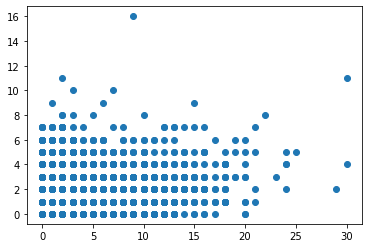

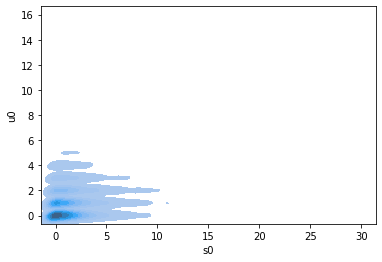

In [27]:
import pandas as pd
gene='Gnao1'#'Syt11'#
genelist_all=vlm.ra["Gene"] #27998 genes
ix=np.where(vlm.ra["Gene"] == gene)[0][0]
print(ix)
print(len(vlm.ca['CellID']))
print(vlm.S.shape)
print(vlm.U.shape)
u=vlm.U[ix,:]
s=vlm.S[ix,:]
plt.scatter(s,u)
data_onegene = pd.DataFrame({'gene': gene, 'u0': u,'s0': s}, columns=['gene', 'u0','s0'])


import seaborn
plt.figure()
seaborn.kdeplot(data=data_onegene,x='s0', y='u0',fill=True)

2022-06-02 17:27:00,797 - DEBUG - Filtering by detection level
2022-06-02 17:27:01,559 - DEBUG - svr_gamma set to 0.06947660954145438


IndexError: index 3000 is out of bounds for axis 0 with size 2159

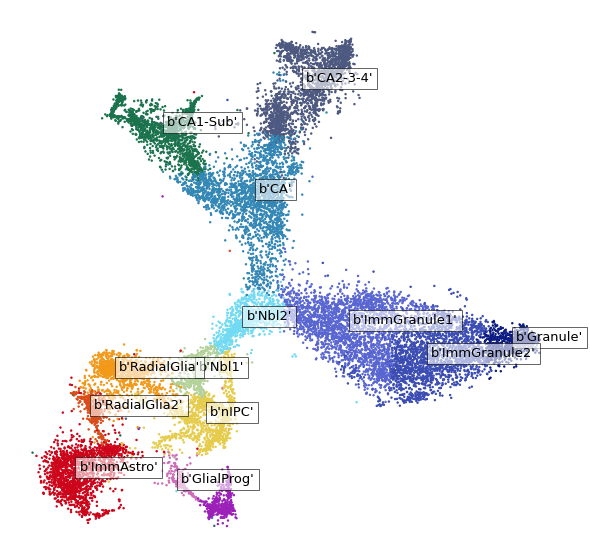

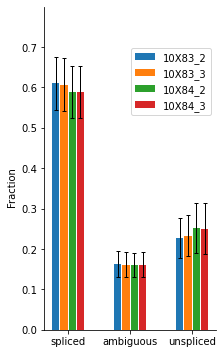

In [ ]:
# Plot TSNE
plt.figure(figsize=(10,10))
vcy.scatter_viz(vlm.ts[:,0], vlm.ts[:,1], c=vlm.colorandum, s=2)
for i in range(max(vlm.ca["Clusters"])):
    ts_m = np.median(vlm.ts[vlm.ca["Clusters"] == i, :], 0)
    plt.text(ts_m[0], ts_m[1], str(vlm.cluster_labels[vlm.ca["Clusters"] == i][0]),
             fontsize=13, bbox={"facecolor":"w", "alpha":0.6})
plt.axis("off");

vlm.plot_fractions()
vlm.filter_cells(bool_array=vlm.initial_Ucell_size > np.percentile(vlm.initial_Ucell_size, 0.4))
vlm.ts = np.column_stack([vlm.ca["TSNE1"], vlm.ca["TSNE2"]])
vlm.score_detection_levels(min_expr_counts=40, min_cells_express=30)
vlm.filter_genes(by_detection_levels=True)
vlm.score_cv_vs_mean(3000, plot=True, max_expr_avg=35)
vlm.filter_genes(by_cv_vs_mean=True)

vlm.score_detection_levels(min_expr_counts=0, min_cells_express=0, min_expr_counts_U=25, min_cells_express_U=20)
vlm.score_cluster_expression(min_avg_U=0.01, min_avg_S=0.08)
vlm.filter_genes(by_detection_levels=True, by_cluster_expression=True)

# best with sample and expression scaling
vlm._normalize_S(relative_size=vlm.initial_cell_size,
                 target_size=np.mean(vlm.initial_cell_size))
vlm._normalize_U(relative_size=vlm.initial_Ucell_size,
                 target_size=np.mean(vlm.initial_Ucell_size))

vlm.perform_PCA()
plt.plot(np.cumsum(vlm.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(vlm.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
n_comps

In [ ]:
k = 500
vlm.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8, b_maxl=k*4, n_jobs=16)

vlm.fit_gammas(limit_gamma=False, fit_offset=False)

vlm.predict_U()
vlm.calculate_velocity()
vlm.calculate_shift(assumption="constant_velocity")
vlm.extrapolate_cell_at_t(delta_t=1.)

plt.figure(None, (17,2.8), dpi=80)
gs = plt.GridSpec(1,6)
#for i, gn in enumerate(["Pdgfra","Igfbpl1"]):
for i, gn in enumerate(["Ntrk2","Igfbpl1"]):
    ax = plt.subplot(gs[i*3])
    try:
        ix=np.where(vlm.ra["Gene"] == gn)[0][0]
    except:
        continue
    vcy.scatter_viz(vlm.Sx_sz[ix,:], vlm.Ux_sz[ix,:], c=vlm.colorandum, s=5, alpha=0.4, rasterized=True)
    plt.title(gn)
    xnew = np.linspace(0,vlm.Sx[ix,:].max())
    plt.plot(xnew, vlm.gammas[ix] * xnew + vlm.q[ix], c="k")
    plt.ylim(0, np.max(vlm.Ux_sz[ix,:])*1.02)
    plt.xlim(0, np.max(vlm.Sx_sz[ix,:])*2.02)
    minimal_yticks(0, np.max(vlm.Ux_sz[ix,:])*1.02)
    minimal_xticks(0, np.max(vlm.Sx_sz[ix,:])*1.02)
    despline()
    
    vlm.plot_velocity_as_color(gene_name=gn, gs=gs[i*3+1], s=3, rasterized=True)

    vlm.plot_expression_as_color(gene_name=gn, gs=gs[i*3+2], s=3, rasterized=True)
    
plt.tight_layout()

# plt.savefig("figures/fig.pdf")

2022-06-02 16:41:08,399 - DEBUG - First search the 4000 nearest neighbours for 18140
2022-06-02 16:41:29,994 - DEBUG - Using the initialization network to find a 500-NN graph with maximum connectivity of 2000
2022-06-02 16:41:30,822 - DEBUG - Returning sparse matrix
2022-06-02 16:41:56,181 - ERROR - Internal Python error in the inspect module.
Below is the traceback from this internal error.

Traceback (most recent call last):
  File "/Users/shengyuli/anaconda3/envs/velocyto/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/0m/7mylm3gs5hj8zfvd2hbr8ntc0000gq/T/ipykernel_2985/912093434.py", line 2, in <module>
    vlm.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8, b_maxl=k*4, n_jobs=16)
  File "/Users/shengyuli/velocyto.py/velocyto/analysis.py", line 1023, in knn_imputation
    self.Sx = convolve_by_sparse_weights(self.S_sz, self.knn_smoothing_w)
  File "/Us

TypeError: object of type 'NoneType' has no len()

In [6]:
len(vlm.ra["Gene"])

2159

In [7]:
vlm.cluster_labels.shape

(18140,)

In [ ]:
import pandas as pd
genelist_all=vlm.ra["Gene"] #2159
vlm.cluster_labels.shape #(18140,)

data=pd.DataFrame()
for g in genelist_all:
    ix=np.where(vlm.ra["Gene"] == g)[0][0]
    data_onegene = pd.DataFrame({'gene': g, 'u0': vlm.Ux_sz[ix,:],'s0': vlm.Sx_sz[ix,:],'clusters':vlm.ca["ClusterName"]}, columns=['gene', 'u0','s0',"clusters"])
    data=data.append(data_onegene,ignore_index=True)

i=0
for g in genelist_all:
    i=i+1
    print("processing:"+str(i)+"/"+"2159")
    ix=np.where(vlm.ra["Gene"] == g)[0][0]
    data_onegene = pd.DataFrame({'gene': g, 'u0': vlm.Ux_sz[ix,:],'s0': vlm.Sx_sz[ix,:],'clusters':vlm.ca["ClusterName"]}, columns=['gene', 'u0','s0',"clusters"])
    data_onegene.to_csv('data/denGyr.csv',mode='a',header=False)

den_gyr=pd.read_csv("data/denGyr.csv",names=['gene', 'u0','s0',"clusters"])

In [14]:
import pandas as pd
load_raw_data=pd.read_csv('/Users/shengyuli/Library/CloudStorage/OneDrive-HoustonMethodist/work/Velocity/data/raw_data/DentateGyrus.csv')
#load_raw_data=pd.read_csv('/Users/shengyuli/Library/CloudStorage/OneDrive-HoustonMethodist/work/Velocity/data/raw_data/PancreaticEndocrinogenesis.csv')
#load_raw_data=pd.read_csv('/Users/shengyuli/Library/CloudStorage/OneDrive-HoustonMethodist/work/Velocity/data/raw_data/mouse_endo_blood20to25_2000_genes_moment100.csv')

genes=list(set(load_raw_data['gene_name']))
cells=load_raw_data[load_raw_data.gene_name==genes[0]]

print(len(genes))
print(len(cells))


2159
18140


In [15]:
import pandas as pd
#load_raw_data=pd.read_csv('/Users/shengyuli/Library/CloudStorage/OneDrive-HoustonMethodist/work/Velocity/data/raw_data/DentateGyrus.csv')
load_raw_data=pd.read_csv('/Users/shengyuli/Library/CloudStorage/OneDrive-HoustonMethodist/work/Velocity/data/raw_data/PancreaticEndocrinogenesis.csv')
#load_raw_data=pd.read_csv('/Users/shengyuli/Library/CloudStorage/OneDrive-HoustonMethodist/work/Velocity/data/raw_data/mouse_endo_blood20to25_2000_genes_moment100.csv')

genes=list(set(load_raw_data['gene_name']))
cells=load_raw_data[load_raw_data.gene_name==genes[0]]

print(len(genes))
print(len(cells))

2000
3696


In [16]:
import pandas as pd
#load_raw_data=pd.read_csv('/Users/shengyuli/Library/CloudStorage/OneDrive-HoustonMethodist/work/Velocity/data/raw_data/DentateGyrus.csv')
#load_raw_data=pd.read_csv('/Users/shengyuli/Library/CloudStorage/OneDrive-HoustonMethodist/work/Velocity/data/raw_data/PancreaticEndocrinogenesis.csv')
load_raw_data=pd.read_csv('/Users/shengyuli/Library/CloudStorage/OneDrive-HoustonMethodist/work/Velocity/data/raw_data/mouse_endo_blood20to25_2000_genes_moment100.csv')

genes=list(set(load_raw_data['gene_name']))
cells=load_raw_data[load_raw_data.gene_name==genes[0]]

print(len(genes))
print(len(cells))

2000
12329
